In [126]:
# Channel: regular mesh, equilateral triangles
# Soufflet et al. 20,10,5 and 2 km meshes.

# Cyclic_length=4.5
# ============
import numpy as np
import matplotlib.pyplot as plt

In [101]:
# Define the number of levels
nl = 41                 # 41 for 10 km, 61 for 5 km
H = 4000                # Depth in m
alpha = 1.1             # The next layer is alpha times thicker, 1.1 for 10 km, 1.06 for 5 km

cyclic_length = 4.5 * 3 # in degrees longittude

# Domain size
re = 6400               # Earth's radius
Lx = cyclic_length * np.pi * re / 180  # In km
Ly = 2010  
# We ensure that the cyclic_length is 4.5, otherwise it is very close to 500 km of Soufflet et al.

# Approximate mesh resolution
dx = 20                 # Mesh resolution in km
nn = np.floor(Lx / dx)
dx = Lx / nn            # dx is close to 10 km, and we have the integer number of intervals within Lx

dy = dx * np.sqrt(3) / 2    # Calculate dy based on equilateral triangles
nn = np.floor(Ly / dy)
dy = Ly / nn            # Adjusted dy to fit evenly into Ly, We ensure that the channel width is exactly Ly

# Convert dx and dy to degrees
dx_deg = dx * 180 / np.pi / re
dy_deg = dy * 180 / np.pi / re

# Generate lon and lat arrays
lon = np.arange(0, cyclic_length + dx_deg, dx_deg)
lat = np.arange(0, 180 * Ly / re / np.pi + dy_deg, dy_deg)

nx = len(lon)
ny = len(lat)

In [106]:
# Initialize arrays
nodnum = np.arange(1, nx * ny + 1).reshape((ny, nx), order='F') #order important for coloumn shapes

xcoord = np.zeros((ny, nx))
ycoord = np.zeros((ny, nx))
xnum = np.zeros((ny, nx))
ynum = np.zeros((ny, nx))

# Fill arrays
for n in range(nx):
    ycoord[:, n] = lat
    ynum[:, n] = np.arange(1, ny + 1)

for n in range(ny):
    xcoord[n, :] = lon
    xnum[n, :] = np.arange(1, nx + 1)

# Adjust xcoord for every second row
for n in range(1, ny, 2):
    xcoord[n, :] += 0.5 * dx_deg

xcoord = xcoord.reshape((1, nx * ny), order='F')
ycoord = ycoord.reshape((1, nx * ny), order='F')

In [108]:
# Generate triangular mesh (tri array)
tri = []
for n in range(nx - 1): #doesnt include nx-1 but therefore 0, replicates 1:n-1 in matlab
    for nn in range(0, ny - 1, 2):
        tri.append([nodnum[nn, n], nodnum[nn + 1, n], nodnum[nn, n + 1]])
        tri.append([nodnum[nn + 1, n], nodnum[nn + 1, n + 1], nodnum[nn, n + 1]])
    for nn in range(1, ny - 1, 2):
        tri.append([nodnum[nn, n], nodnum[nn + 1, n], nodnum[nn + 1, n + 1]])
        tri.append([nodnum[nn, n], nodnum[nn + 1, n + 1], nodnum[nn, n + 1]])

tri = np.array(tri)

In [112]:
# Cyclic reduction:
# The last ny nodes in xcoord, ycoord are equivalent to the first ny nodes.
ai = np.where(tri > (nx - 1) * ny)
tri[ai] -= (nx - 1) * ny
xcoord = xcoord[0,: (nx - 1) * ny] #xcoords is somehow array in an array
ycoord = ycoord[0,: (nx - 1) * ny]

# Cyclic reduction means that the last column has to be removed in xnum, ynum
xnum = xnum[:, :nx - 1].reshape((ny * (nx - 1), 1), order='F')
ynum = ynum[:, :nx - 1].reshape((ny * (nx - 1), 1), order='F')

#Fill array 
n2d = (nx - 1) * ny
nodes = np.zeros((4, n2d))
nodes[0, :] = np.arange(1, n2d + 1)
nodes[1, :] = xcoord
nodes[2, :] = ycoord
nodes[3, :] = np.zeros_like(ycoord) # zeros_like takes same shape as argument

# Set indices to 1 on vertical walls
ai = np.where(ycoord == np.min(lat))#[0]
nodes[3, ai] = 1
ai = np.where(ycoord == np.max(lat))#[0]
nodes[3, ai] = 1

# Define levels:
dz = H * (1 - alpha) / (1 - alpha**(nl - 1)) #dz of the top layer; then alpha*dz,...
zbar = np.zeros(nl)
zbar[1] = dz
for n in range(2, nl):
    zbar[n] = zbar[n-1] * alpha

for n in range(0, nl-1):
    zbar[n+1] = zbar[n] + zbar[n+1]

dd = -H * np.ones_like(xcoord)

In [125]:
# only run this cell if you want to add topography. still in test phase
def gaussian_bump_2d(x, y, hmax, sigmax, sigmay, x0=2.2, y0=10):
    return hmax * np.exp((- ((x - x0)**2 / 2 / sigmax + (y - y0)**2 / 2 / sigmay)))
    
dd = [gaussian_bump_2d(x, y, 2000, sigmax=0.25, sigmay=3) - 4000 for x, y in zip(xcoord, ycoord)]

In [111]:
dd = [gaussian_bump_2d(x, y, 2000, sigmax=0.25, sigmay=3) - 4000 for x, y in zip(xcoord, ycoord)]

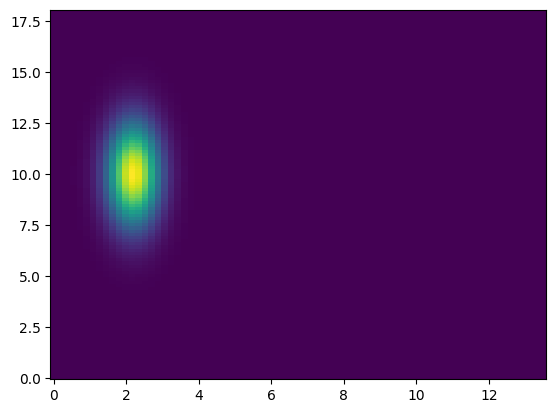

In [122]:
lat_m, lon_m = np.meshgrid(lat, lon)
plt.pcolormesh(lon_m, lat_m, gaussian_bump_2d(lon_m, lat_m, 2000, sigmax=0.25, sigmay=3))

In [138]:
nodes[1].max()

13.41

In [117]:
# Output 2D mesh
with open('nod2d.out', 'w') as fid:
    fid.write(f'{n2d:8d}\n')
    for i in range(nodes.shape[1]):
        fid.write(f'{int(nodes[0, i]):8d} {nodes[1, i]:8.4f} {nodes[2, i]:8.4f} {int(nodes[3, i]):8d}\n')

In [118]:
with open('elem2d.out', 'w') as fid:
    fid.write(f'{len(tri[:, 0]):8d}\n')
    for i in range(len(tri)):
        fid.write(f'{tri[i, 0]:8d} {tri[i, 1]:8d} {tri[i, 2]:8d}\n')

In [120]:
with open('aux3d.out', 'w') as fid:
    fid.write(f'{nl:g}\n')
    for i in range(len(zbar)):
        fid.write(f'{zbar[i]:g}\n')
    for i in range(len(dd)):
        fid.write(f'{dd[i]:7.1f}\n')

(0.0, 1.0)

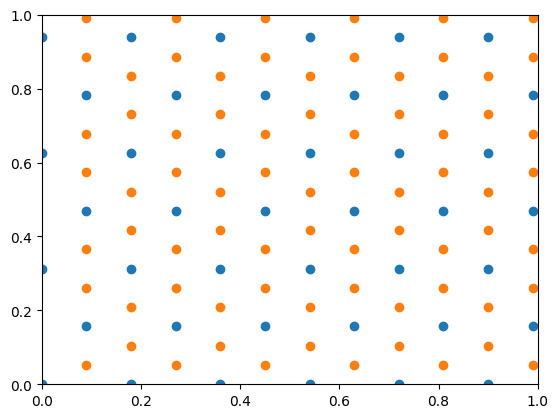

In [185]:
plt.scatter(xcoord, ycoord)
plt.scatter(x_elems, y_elems)
plt.xlim(0, 1)
plt.ylim(0, 1)

0.27

In [172]:
nodes.

(4, 8700)

In [175]:
coords_elems = []
for elem in tri:
    x_nodes = nodes[1, elem - 1]
    y_nodes = nodes[2, elem - 1]
    x_elem = x_nodes.sum()/3
    y_elem = y_nodes.sum()/3
    coords_elems.append([x_elem, y_elem])

In [168]:
array_elems = np.asarray(coords_elems)

In [179]:
x_elems, y_elems = array_elems.T

In [184]:
y_elems.shape

(17250,)

In [152]:
mesh_diag

NameError: name 'mesh_diag' is not defined